In [37]:
#importing all the required libraries
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd

In [38]:
# reading the 3D Points Data and storing it in pcd file
pcd = o3d.io.read_point_cloud(r"C:\Users\Radhakanta Koner\Desktop\set2modelclean.ply")
o3d.visualization.draw_geometries([pcd])

In [39]:
# Removing the plane surface on which rock stays, (ROCKS ARE IN GREY COLOR AND SURFACE IS IN RED COLOR)
# We would like to study on 3d rock cloud by removing plane surface
plane_model, inliers = pcd.segment_plane(distance_threshold=0.05, ransac_n=3, num_iterations=1000)
inlier_cloud = pcd.select_by_index(inliers)
rock_cloud = pcd.select_by_index(inliers, invert=True)
inlier_cloud.paint_uniform_color([1, 0, 0])
rock_cloud.paint_uniform_color([0.6, 0.6, 0.6])
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=16), fast_normal_computation=True)
o3d.visualization.draw_geometries([inlier_cloud, rock_cloud])


In [40]:
# Creating Labels for each individual Cluster i.e 0,1,2 for Each rock (i.e total 3 rock clusters)

labels = np.array(rock_cloud.cluster_dbscan(eps=0.07, min_points= 50 ))
max_label = labels.max()
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0 
rock_cloud.colors = o3d.utility.Vector3dVector(colors[:, :3])
max_label 

68

In [41]:
o3d.visualization.draw_geometries([rock_cloud])

In [42]:
rock_cloud # no of whole 3d points of rock_cloud

PointCloud with 788357 points.

In [43]:
with o3d.utility.VerbosityContextManager(
o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(rock_cloud.cluster_dbscan(eps=0.07, min_points=50, print_progress=True))

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 69


In [44]:
if len(labels) != 0:
    # Get biggest cluster label
    max_label = labels.max() + 1


In [45]:
max_label = labels.max() + 1
# print(max_label)
for i in range(max_label):
    id = np.where(labels==i)[0]
    pcd_i = rock_cloud.select_by_index(id)
    #o3d.visualization.draw_geometries([pcd_i])
    x = str(i)
    
    #saving individual rocks into different ply point cloud files.
    #o3d.io.write_point_cloud(r"C:\Users\Radhakanta Koner\Desktop\3DFM" + x + ".ply", pcd_i)

In [46]:
for i in range(max_label):
    id = np.where(labels==i)[0]
    pcd_i = pcd.select_by_index(id)
    hull, _ = pcd_i.compute_convex_hull()
    hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
    hull_ls.paint_uniform_color((1, 0, 0))
    o3d.visualization.draw_geometries([pcd_i, hull_ls ])

In [47]:
from __future__ import division
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d import Axes3D
from math import *
%matplotlib inline
import matplotlib as mpl

In [48]:
def minboundrect(hull_points_3d,Epsilon):
    a=[]
    boxes=[]
    count = 0
    min_bbox = (0, 0, sys.maxsize, 0, 0, 0, 0, 0, 0, 0, 0, 0) 
    angi=np.arange(0.0, 90, Epsilon)

    for iDeg in (angi):
        boxes.append([])
        angj=np.arange(0.0, 180, Epsilon)
        for jDeg in (angj):
            
            i=deg2rad(iDeg)
            j=deg2rad(jDeg)
            
            R = array([ [ math.cos(i),                                       -math.cos(i-(math.pi/2)),              0],
                        [ math.cos(j)*math.cos(i-(math.pi/2))  ,             math.cos(j)*math.cos(i), -math.cos(j-(math.pi/2)) ],
                        [ math.cos(i-(math.pi/2)) * math.cos(j-(math.pi/2)), math.cos(j-(math.pi/2))*math.cos(i),  math.cos(j) ] ])

            rot_points = matmul((hull_points_3d), R )

            a.append(rot_points)

            min_x = nanmin(rot_points[:,0], axis=0)
            max_x = nanmax(rot_points[:,0], axis=0)
            min_y = nanmin(rot_points[:,1], axis=0)
            max_y = nanmax(rot_points[:,1], axis=0)
            min_z = nanmin(rot_points[:,2], axis=0)
            max_z = nanmax(rot_points[:,2], axis=0)
            width = max_x - min_x
            height = max_y - min_y
            depth = max_z-min_z
            Volume = width * height * depth

            boxes[count].append(Volume)

            if (Volume < min_bbox[2]):
                min_bbox = ( i,j, Volume, width, height, depth, min_x, max_x, min_y, max_y, min_z, max_z )
        count=count+1
        
    i = min_bbox[0]
    j = min_bbox[1]
    R = array([ [ math.cos(i),                                       -math.cos(i-(math.pi/2)),              0],
                [ math.cos(j)*math.cos(i-(math.pi/2))  ,             math.cos(j)*math.cos(i), -math.cos(j-(math.pi/2)) ],
                [ math.cos(i-(math.pi/2)) * math.cos(j-(math.pi/2)), math.cos(j-(math.pi/2))*math.cos(i),  math.cos(j)             ] ])

    rot_points = matmul((hull_points_3d), R )
    

    min_x = min_bbox[6]
    max_x = min_bbox[7]
    min_y = min_bbox[8]
    max_y = min_bbox[9]
    min_z = min_bbox[10]
    max_z = min_bbox[11]

    center_x = (min_x + max_x)/2
    center_y = (min_y + max_y)/2
    center_z = (min_x + max_x)/2
    center_point = matmul(linalg.inv(R) , [ center_x, center_y, center_z])

    corner_points = zeros( (16,3) ) # empty 2 column array
    corner_points[0] = matmul(  (R) ,[ min_x, min_y ,min_z ])
    corner_points[1] = matmul(  (R), [ max_x, min_y ,min_z ])
    corner_points[2] = matmul(  (R), [ max_x, max_y ,min_z ])
    corner_points[3] = matmul(  (R), [ min_x, max_y ,min_z ])
    corner_points[4] = matmul(  (R), [ min_x, min_y ,min_z ])
    
    corner_points[5] = matmul( (R), [ min_x, min_y ,max_z ])
    corner_points[6] = matmul( (R), [ max_x, min_y ,max_z ])
    corner_points[7] = matmul( (R), [ max_x, max_y ,max_z ])
    corner_points[8] = matmul( (R), [ min_x, max_y ,max_z ])
    corner_points[9] = matmul( (R), [ min_x, min_y ,max_z ])

    corner_points[10] = matmul( (R), [ max_x, min_y ,max_z ])
    corner_points[11] = matmul( (R), [ max_x, min_y ,min_z ])
    
    corner_points[12] = matmul( (R), [ max_x, max_y ,min_z ] )
    corner_points[13] = matmul( (R), [ max_x, max_y ,max_z ])

    corner_points[14] = matmul( (R), [ min_x, max_y ,max_z ])
    corner_points[15] = matmul( (R), [ min_x, max_y ,min_z ])

    return ( i, j, min_bbox[2], min_bbox[3], min_bbox[4], min_bbox[5], center_point, corner_points,a,boxes,rot_points)

In [49]:
xyz_load = np.asarray(hull_ls.points)

Minimum Volume bounding box:
Rotation angles:
Along z axes:  1.5446163880149817 rad  ( 88.5 deg )
Along x axes:  1.509709802975095 rad  ( 86.5 deg )
Width: 0.8190928402656876  Height: 7.311267090838937  Depth: 6.850618037726031   Volume: 41.02565589728805
Center point: 
 [ 7.51779261 -7.48223914  6.07329589]
Corner points: 
 [[ 9.4578146   0.57579035  6.99965568]
 [ 9.47925595  0.62577763  7.81694058]
 [ 2.17049425  0.63746151  8.00797027]
 [ 2.14905289  0.58747422  7.19068536]
 [ 9.4578146   0.57579035  6.99965568]
 [ 9.4578146  -6.26204991  7.4178759 ]
 [ 9.47925595 -6.21206262  8.23516081]
 [ 2.17049425 -6.20037874  8.4261905 ]
 [ 2.14905289 -6.25036603  7.60890559]
 [ 9.4578146  -6.26204991  7.4178759 ]
 [ 9.47925595 -6.21206262  8.23516081]
 [ 9.47925595  0.62577763  7.81694058]
 [ 2.17049425  0.63746151  8.00797027]
 [ 2.17049425 -6.20037874  8.4261905 ]
 [ 2.14905289 -6.25036603  7.60890559]
 [ 2.14905289  0.58747422  7.19068536]] 



Text(0.5, 0.92, 'Minimum Volume Bounding Box')

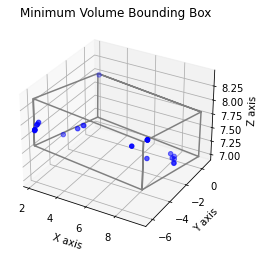

In [50]:
Epsilon = 0.5
(rot_angle1, rot_angle2, Volume, width, height, depth, center_point, corner_points,a,boxes,
 rot_points) = minboundrect(xyz_load,Epsilon)

print ("Minimum Volume bounding box:")
print ("Rotation angles:")
print("Along z axes: ", rot_angle1, "rad  (", rot_angle1*(180/math.pi), "deg )")
print("Along x axes: ", rot_angle2, "rad  (", rot_angle2*(180/math.pi), "deg )")
print ("Width:", width, " Height:", height, " Depth:", depth, "  Volume:", Volume)
print ("Center point: \n", center_point)
print ("Corner points: \n", corner_points, "\n")

fig = plt.figure(4)
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(corner_points[:, 0], corner_points[:, 1], corner_points[:, 2], 'gray')
ax.scatter(xyz_load[:, 0], xyz_load[:, 1], xyz_load[:, 2], s=20, c='b', zorder=10)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('Minimum Volume Bounding Box')

In [52]:
Epsilon = 0.5
for i in range(max_label):
    id = np.where(labels==i)[0]
    pcd_i = pcd.select_by_index(id)
    hull, _ = pcd_i.compute_convex_hull()
    hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
    hull_ls.paint_uniform_color((1, 0, 0))
    xyz_load = np.asarray(hull_ls.points)
    (rot_angle1, rot_angle2, Volume, width, height, depth, center_point, corner_points,a,boxes,rot_points) = minboundrect(xyz_load,Epsilon)
    Dimension =  min(width,height,depth)
    print ("Minimum Volume bounding box:", i )
    print ("Rock_No:", i , " |Width(cm):", "{:.2f}".format(width), "|Height(cm):", "{:.2f}".format(height) , "|Depth(cm):", "{:.2f}".format(depth),"|Small Dimension(cm):" ,"{:.2f}".format(Dimension), "|Volume(cm3):",  "{:.2f}".format(Volume))

Minimum Volume bounding box: 0
Rock_No: 0  |Width(cm): 1.87 |Height(cm): 8.68 |Depth(cm): 7.41 |Small Dimension(cm): 1.87 |Volume(cm3): 120.43
Minimum Volume bounding box: 1
Rock_No: 1  |Width(cm): 1.87 |Height(cm): 8.68 |Depth(cm): 7.41 |Small Dimension(cm): 1.87 |Volume(cm3): 120.09
Minimum Volume bounding box: 2
Rock_No: 2  |Width(cm): 1.90 |Height(cm): 8.68 |Depth(cm): 7.41 |Small Dimension(cm): 1.90 |Volume(cm3): 121.97
Minimum Volume bounding box: 3
Rock_No: 3  |Width(cm): 1.86 |Height(cm): 8.67 |Depth(cm): 7.41 |Small Dimension(cm): 1.86 |Volume(cm3): 119.71
Minimum Volume bounding box: 4
Rock_No: 4  |Width(cm): 1.11 |Height(cm): 8.68 |Depth(cm): 7.40 |Small Dimension(cm): 1.11 |Volume(cm3): 71.09
Minimum Volume bounding box: 5
Rock_No: 5  |Width(cm): 0.98 |Height(cm): 8.27 |Depth(cm): 7.22 |Small Dimension(cm): 0.98 |Volume(cm3): 58.77
Minimum Volume bounding box: 6
Rock_No: 6  |Width(cm): 0.91 |Height(cm): 8.53 |Depth(cm): 7.32 |Small Dimension(cm): 0.91 |Volume(cm3): 56.78
Mi

Minimum Volume bounding box: 58
Rock_No: 58  |Width(cm): 1.04 |Height(cm): 8.49 |Depth(cm): 7.39 |Small Dimension(cm): 1.04 |Volume(cm3): 65.52
Minimum Volume bounding box: 59
Rock_No: 59  |Width(cm): 1.05 |Height(cm): 8.66 |Depth(cm): 7.39 |Small Dimension(cm): 1.05 |Volume(cm3): 67.34
Minimum Volume bounding box: 60
Rock_No: 60  |Width(cm): 1.78 |Height(cm): 8.67 |Depth(cm): 7.41 |Small Dimension(cm): 1.78 |Volume(cm3): 114.34
Minimum Volume bounding box: 61
Rock_No: 61  |Width(cm): 1.90 |Height(cm): 8.68 |Depth(cm): 7.41 |Small Dimension(cm): 1.90 |Volume(cm3): 121.99
Minimum Volume bounding box: 62
Rock_No: 62  |Width(cm): 0.31 |Height(cm): 7.88 |Depth(cm): 5.34 |Small Dimension(cm): 0.31 |Volume(cm3): 13.01
Minimum Volume bounding box: 63
Rock_No: 63  |Width(cm): 1.79 |Height(cm): 8.19 |Depth(cm): 7.38 |Small Dimension(cm): 1.79 |Volume(cm3): 108.23
Minimum Volume bounding box: 64
Rock_No: 64  |Width(cm): 0.33 |Height(cm): 7.25 |Depth(cm): 7.31 |Small Dimension(cm): 0.33 |Volume(c